In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('data/train-2.csv')
df.head()
df.isnull().sum(axis = 0)

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

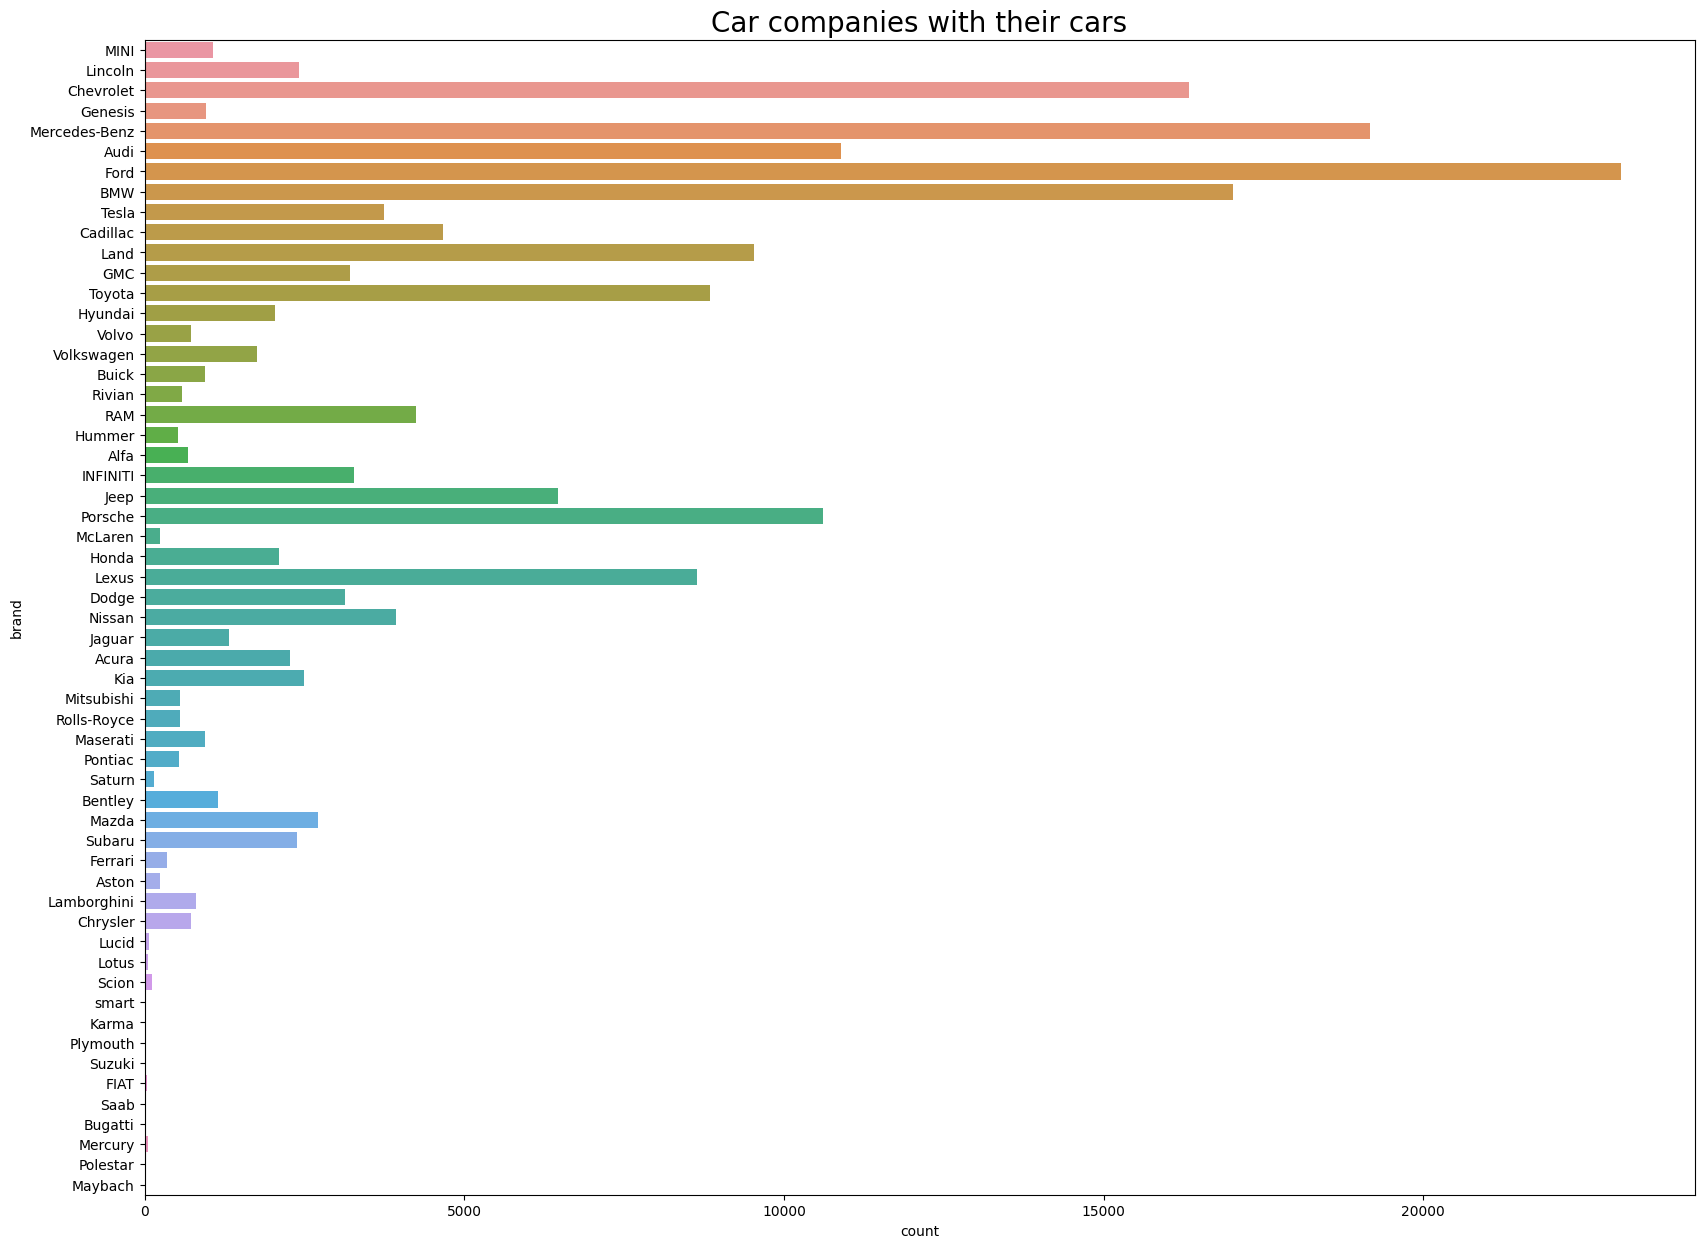

In [3]:
plt.figure(figsize = (20, 15))
sns.countplot(y = df["brand"])
plt.title("Car companies with their cars", fontsize = 20)
plt.show()

<AxesSubplot: xlabel='model_year', ylabel='count'>

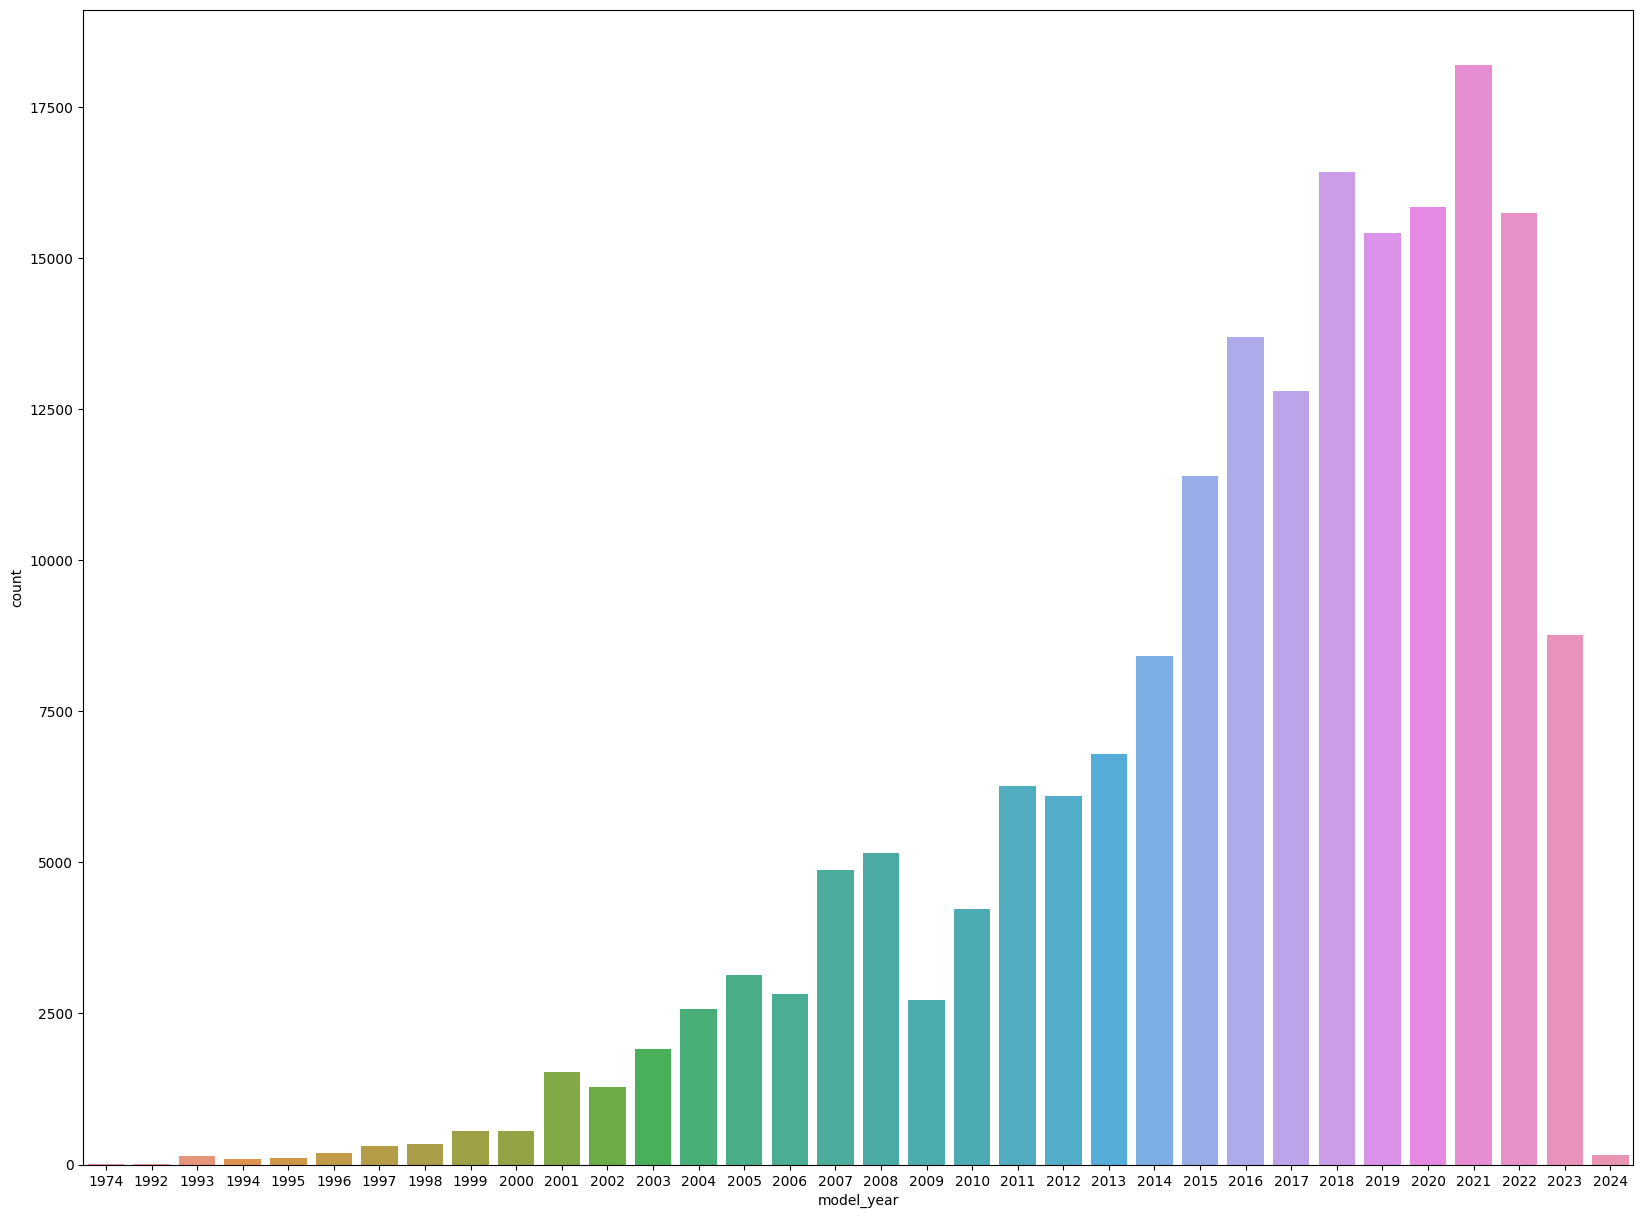

In [4]:
plt.figure(figsize = (20, 15))
sns.countplot(df, x = "model_year")

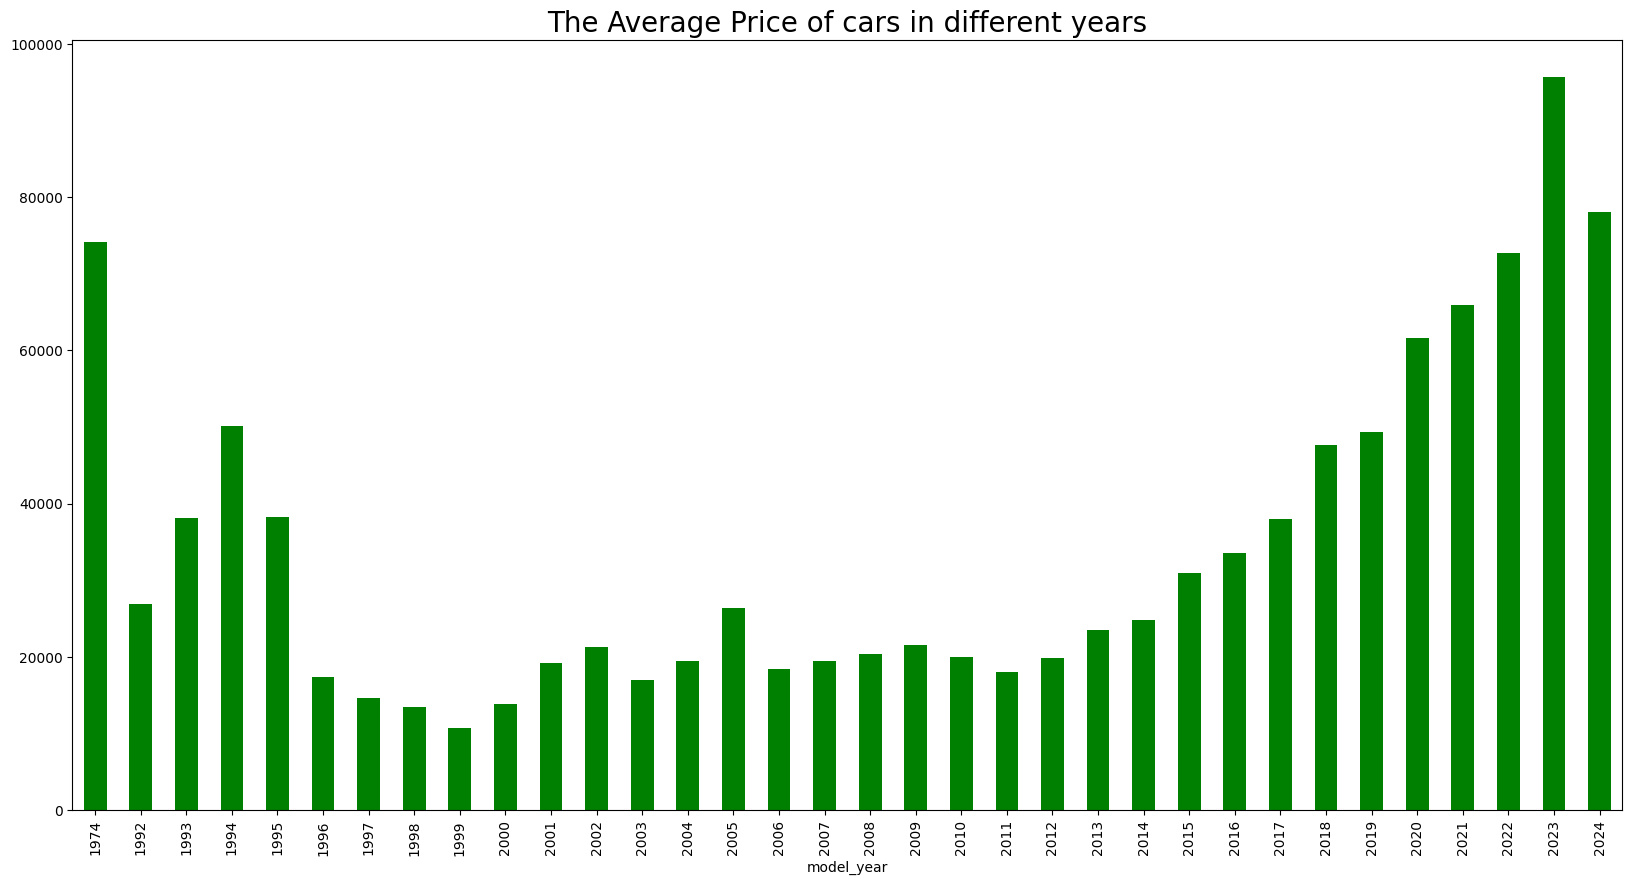

In [5]:
plt.figure(figsize = (20, 10))
df.groupby('model_year')['price'].mean().plot(kind = 'bar', color = 'g')
plt.title("The Average Price of cars in different years", fontsize = 20)
plt.show()

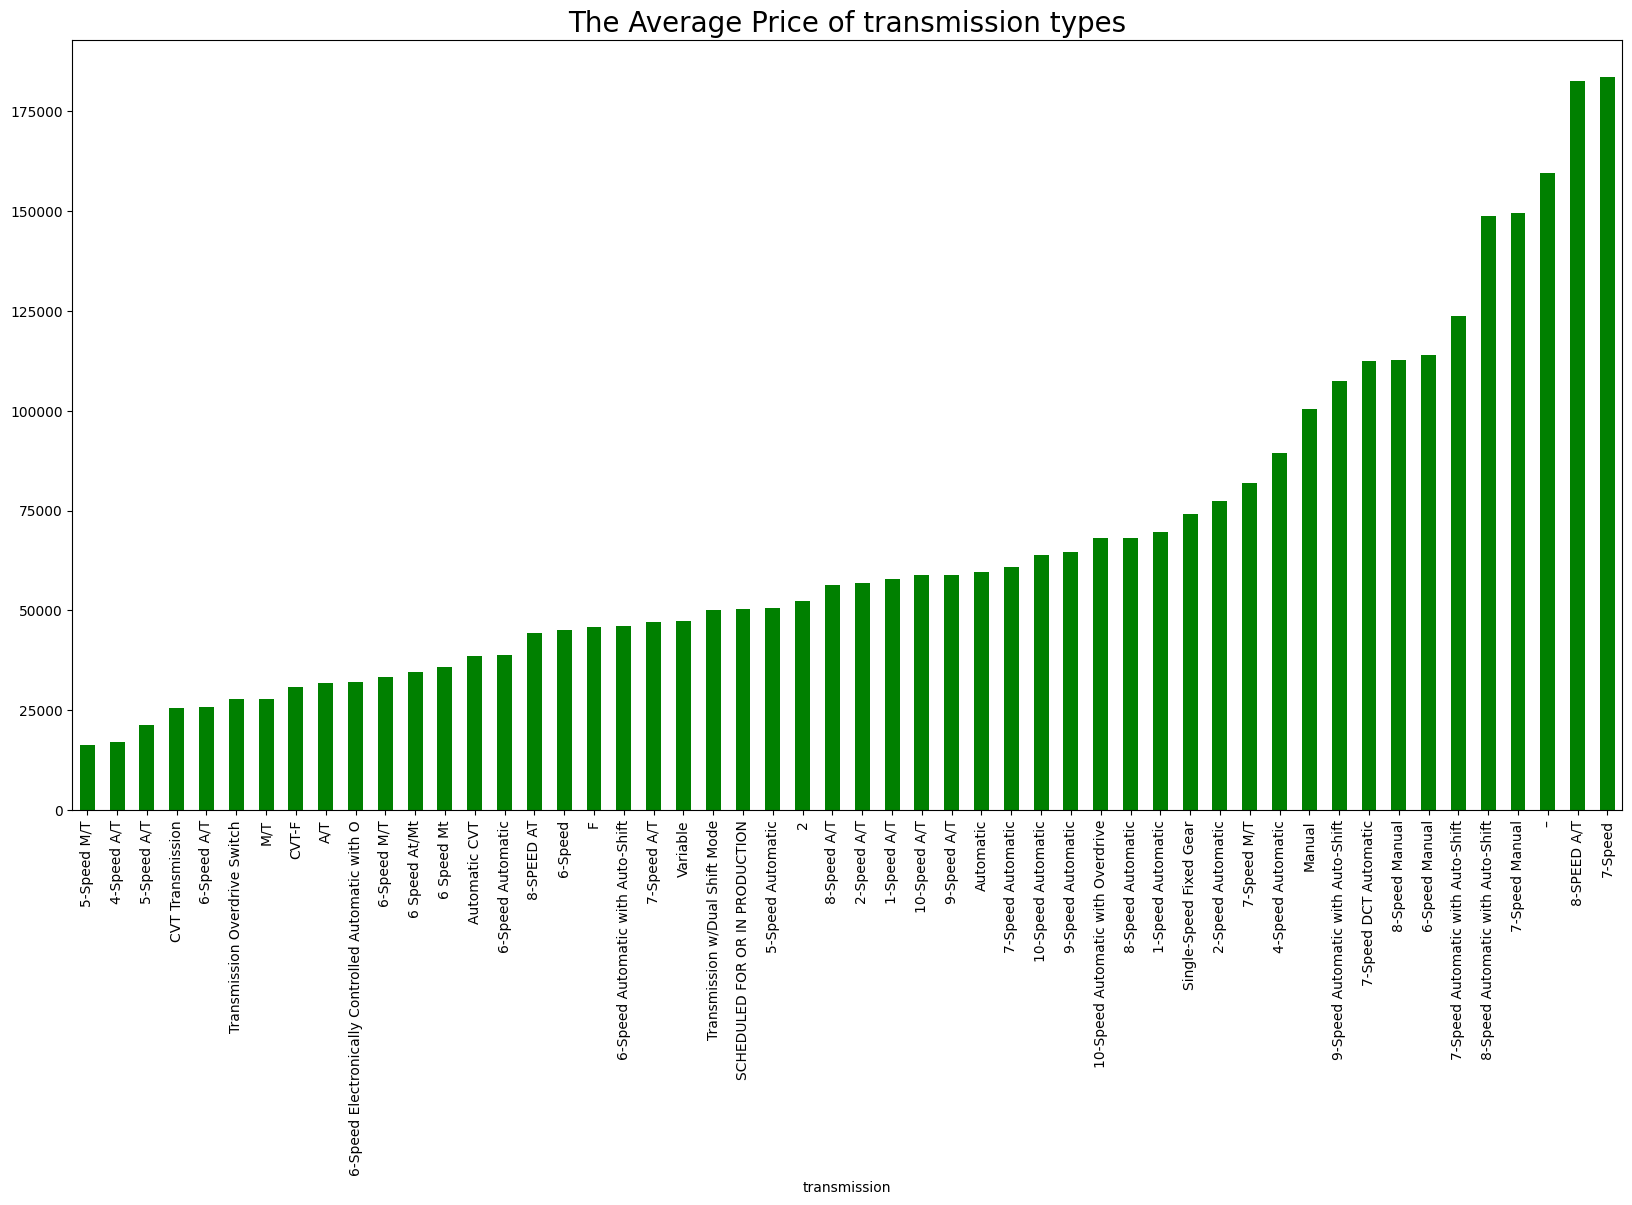

In [6]:
plt.figure(figsize = (20, 10))
df.groupby('transmission')['price'].mean().sort_values().plot.bar(color = 'g')
plt.title("The Average Price of transmission types", fontsize = 20)
plt.show()

/var/folders/4w/r3wqy9sx29x_q3nlp7zqhv480000gn/T/ipykernel_29854/1035323734.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['brand']).mean()['price'].sort_values(ascending = False).plot.bar(fontsize = 15, color = 'black')


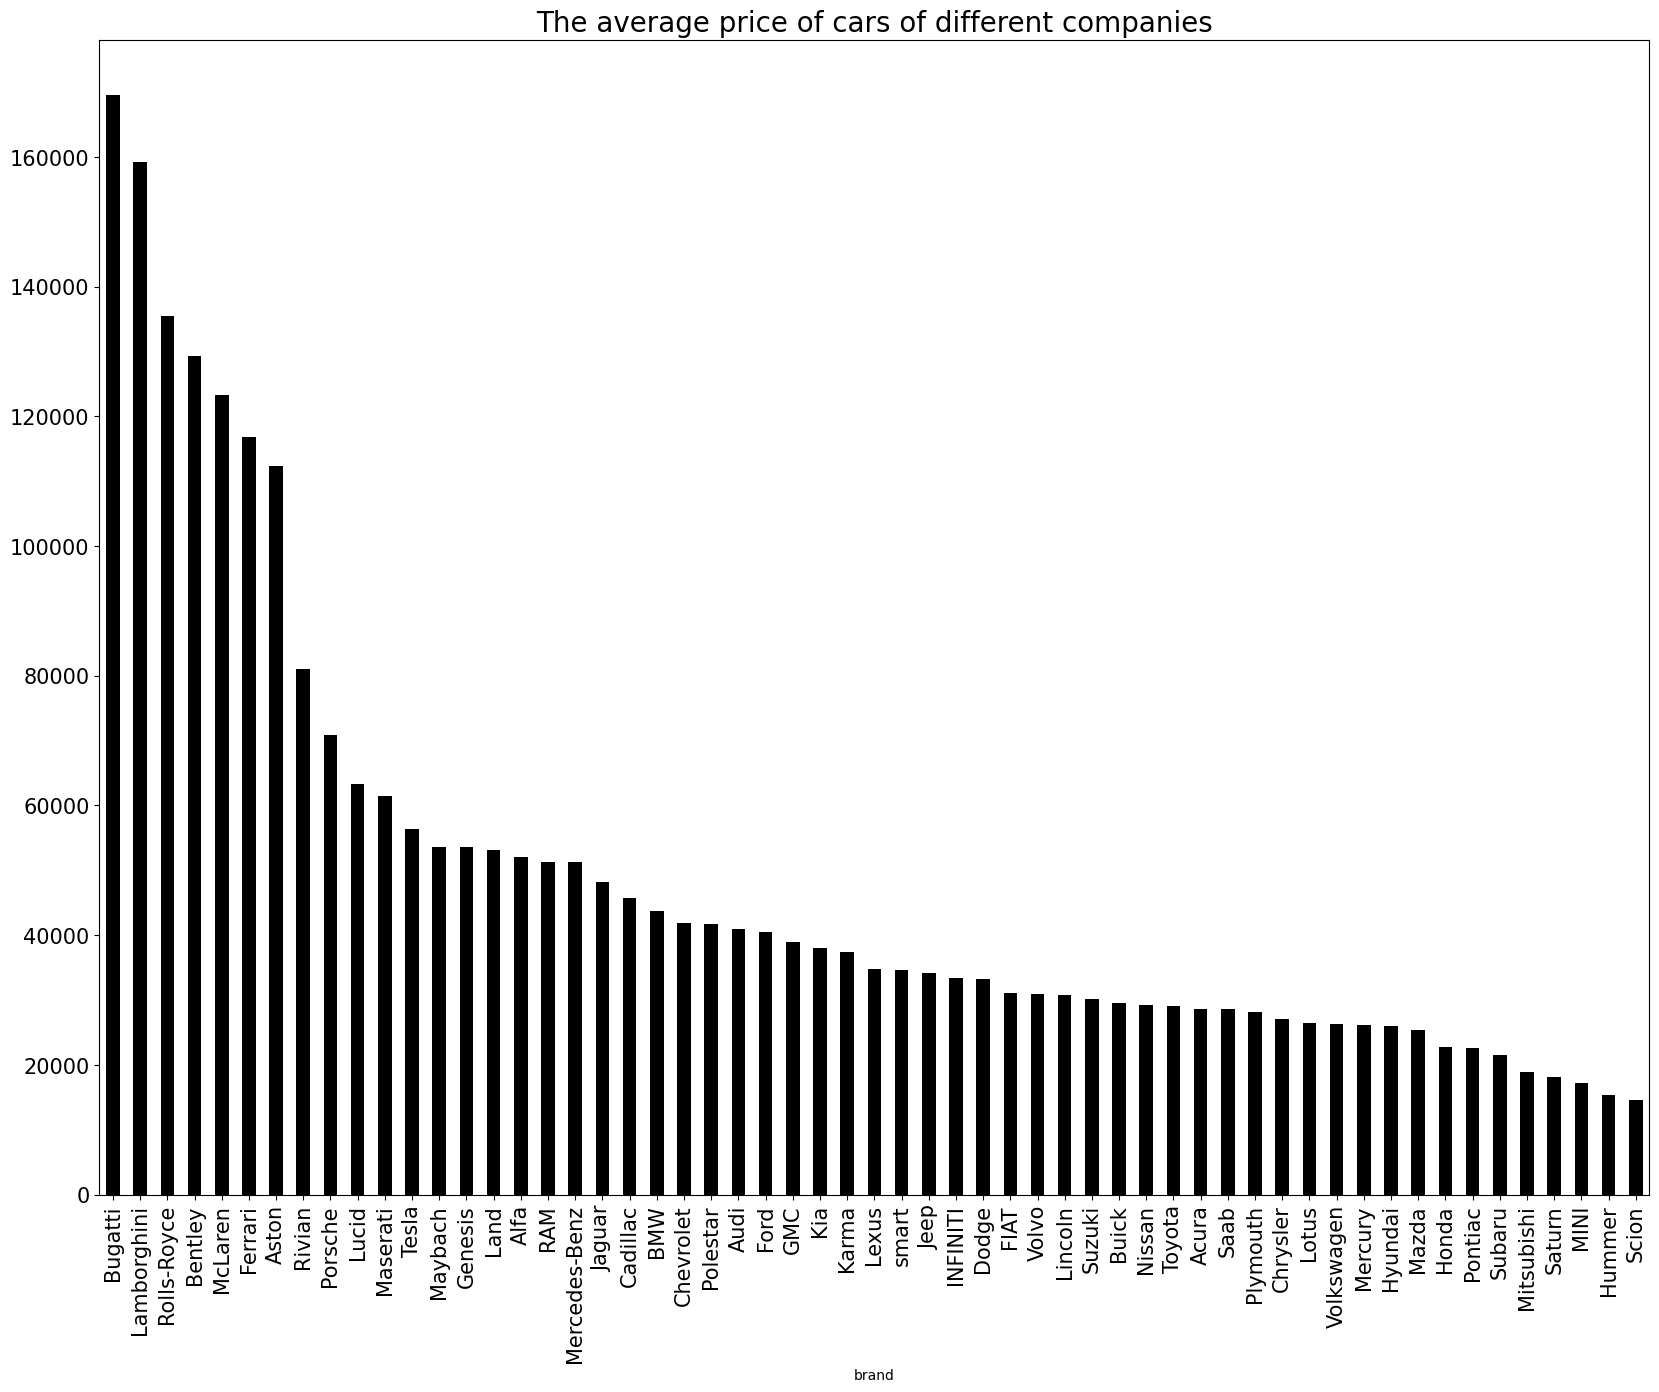

F-150 XLT                   2945
M3 Base                     2229
Camaro 2SS                  1709
M4 Base                     1622
Mustang GT Premium          1526
                            ... 
Wrangler X                   100
Town & Country Touring-L     100
Bentayga V8                  100
CR-V EX                      100
X1 xDrive28i                 100
Name: model, Length: 480, dtype: int64

In [14]:
plt.figure(figsize = (20, 15))
df.groupby(['brand']).mean()['price'].sort_values(ascending = False).plot.bar(fontsize = 15, color = 'black')
plt.title("The average price of cars of different companies", fontsize = 20)
plt.show()

In [7]:
from string import digits
from sklearn.base import BaseEstimator, TransformerMixin
import re

def remove_numbers_from_string(s):
    result = ''.join([i for i in s if not i.isdigit()])
    result = ''.join([i for i in result if not i == "."])

    return result

def fuel_parser(s):
    for fuel in fuel_list:

        if fuel in s:
            return fuel
        
    for fuel in fuel_list_engine:
        if fuel in s:
            return fuel_list_dict[fuel]
    
    return pd.NA

split_engine = df.engine.apply(remove_numbers_from_string)

results = set()
split_engine.str.lower().str.split().apply(results.update)
print(results)

fuel_list_engine = ["plug-in", "diesel", "hybrid", "gdi", "pdi", "gasoline", 
                    "electric", "hydrogen", "flexible", "flex"]

fuel_list_dict= {"plug-in": "plug-in hybrid",
                 "gdi": "gasoline",
                 "pdi": "diesel",
                 "flexible": "flex",
                 "e85 flex fuel": "flex"}

fuel_list = ["plug-in hybrid", "hybrid", "gasoline",
             "diesel", "flex", "electric", "hydrogen"]
    
df = df.applymap(lambda s: s.lower() if type(s) == str else s)
        
df["fuel_type_engine"] = df["engine"].apply(lambda x: fuel_parser(x) if type(x) == str else x)
df["fuel_type"] = df["fuel_type"].apply(lambda x: fuel_parser(x) if type(x) == str else x)

condition = (df["fuel_type"] != df["fuel_type_engine"]) & (~df["fuel_type_engine"].isna())
df.loc[condition, "fuel_type"] = df["fuel_type_engine"]
df = df.drop(columns = ["fuel_type_engine"])



{'/', 'gas/electric', 'l', 'ddi', 'motors', 'cylinder', 'hybrid', 'intercooled', 'sidi', 'mpfi', 'hp', 'motor', 'flexible', 'l/', 'battery', 'w', 'i-', 'rr', 'straight', 'flat', 'dohc', 'electric/gas', 'ulev', 'system', 'sohc', '–', 'electric', 'tfsi', 't/c', 'h', 'v', 'sc', 'v-', 'hydrogen', 'diesel', 'i-vtec', 'premium', 'ac', 'gasoline/mild', 'capability', 'dual', 'standard', 'plug-in', 'range', 'unleaded', 'tsi', 'fuel', 'ah', 'engine', 'i', 'twin', 'liter', 'fr', 'ohv', 'gasoline', 'gtdi', '(v)', 'rotary', 'gdi', 'flex', 'supercharged', '-', 'kw', 'pdi', 'turbo'}


In [8]:
import re
from sklearn.impute import SimpleImputer

hp_pattern = r'(\d+\.?\d*)(\s*hp)'      

liters_pattern = r'(\d+\.?\d*)(\s*l)'     
liters_pattern_full = r'(\d+\.?\d*\s*liter)' 

cylinder_pattern = r'(\d+)\s*cylinder'
cylinder_pattern_letter = r'v|h|w|i-?(\d)'
cylinder_pattern_flat = r'flat\s(\d)'

def extract_engine_info(engine_str):
    hp = re.search(hp_pattern, engine_str)
    
    liters = re.search(liters_pattern, engine_str)
    if not liters:
        liters = re.search(liters_pattern_full, engine_str)
        
    cylinders_str = False    
    cylinders = re.search(cylinder_pattern, engine_str)
    if not cylinders:
        cylinders = re.search(cylinder_pattern_letter, engine_str)
        if not cylinders:
            cylinders = re.search(cylinder_pattern_flat, engine_str)
    
    return {
        'power(HP)': float(hp.group(1)) if hp else pd.NA,
        'displacement(L)': float(liters.group(1)) if liters else pd.NA,
        'n_cylinders': float(cylinders_str) if cylinders else pd.NA,
    }

engine_info_dicts = df["engine"].apply(extract_engine_info)

new_features = pd.DataFrame(list(engine_info_dicts))
df["power(HP)"] = new_features["power(HP)"]
df["displacement(L)"] = new_features["displacement(L)"]
df["n_cylinders"] = new_features["n_cylinders"]

In [9]:
def estimate_cylinders(engine_string):
    if "turbo" in engine_string:
        return 4  # Muchos motores turbo son I4 o V6
    else:
        return 6  

def estimate_displacement(engine_string, cylinders):
    if "turbo" in engine_string:
                return 2.0  # Motores turbo tienden a ser más pequeños
    if cylinders == 4:
        return 2.5
    if cylinders == 6:
        return 3.5
    if cylinders in [8,10,12,14,16]:
        return 5
    
    return 3

def estimate_horsepower(engine_str, cylinders):
    if cylinders == 8:
        if 'Turbo' in engine_str:
            return (400 + 500) / 2  
        elif 'GDI' in engine_str or 'DOHC' in engine_str or 'MPFI' in engine_str:
            return (350 + 450) / 2  
        else:
            return (300 + 400) / 2
    elif cylinders == 6:
        if 'Turbo' in engine_str:
            return (300 + 400) / 2 
        elif 'GDI' in engine_str or 'DOHC' in engine_str or 'MPFI' in engine_str:
            return (250 + 350) / 2 
        else:
            return (200 + 300) / 2
    elif cylinders == 4:
        if 'Turbo' in engine_str:
            return (200 + 300) / 2
        elif 'GDI' in engine_str or 'MPFI' in engine_str or 'DOHC' in engine_str:
            return (150 + 250) / 2 
        else:
            return (100 + 200) / 2 
    elif cylinders == 10:
        if 'Turbo' in engine_str:
            return (600 + 800) / 2
        elif 'GDI' in engine_str or 'DOHC' in engine_str or 'MPFI' in engine_str:
            return (500 + 600) / 2  
        else:
            return (400 + 600) / 2 
    elif cylinders == 12:
        if 'Turbo' in engine_str:
            return (700 + 900) / 2 
        elif 'GDI' in engine_str or 'DOHC' in engine_str or 'MPFI' in engine_str:
            return (600 + 800) / 2  
        else:
            return (500 + 700) / 2 
    elif 'OHV' in engine_str:
        return (200 + 300) / 2 
    else:
        return pd.NA
    
df.loc[(df["displacement(L)"].isna()) & (df["fuel_type"] == "electric"),
       "displacement(L)"] = 0

df.loc[(df["n_cylinders"].isna()) & (df["fuel_type"] == "hybrid"),
       "n_cylinders"] = 4

df.loc[df["fuel_type"].isna(), "fuel_type"] = "gasoline"


estimated_cylinders = df["engine"][df["n_cylinders"].isna()].apply(estimate_cylinders)
df.loc[df["n_cylinders"].isna(), "n_cylinders"] = estimated_cylinders

estimated_displacement = df[df["displacement(L)"].isna()].apply(lambda row: estimate_displacement(row['engine'], 
                                                                row['n_cylinders']), axis=1)
df.loc[df["displacement(L)"].isna(), "displacement(L)"] = estimated_displacement

estimated_hp = df[df["power(HP)"].isna()].apply(lambda row: estimate_displacement(row['engine'], 
                                                                row['n_cylinders']), axis=1)
df.loc[df["power(HP)"].isna(), "power(HP)"] = estimated_hp

df.isnull().sum(axis = 0)

#df.drop(columns = ["engine"], inplace = True)

id                     0
brand                  0
model                  0
model_year             0
milage                 0
fuel_type              0
engine                 0
transmission           0
ext_col                0
int_col                0
accident            2452
clean_title        21419
price                  0
power(HP)              0
displacement(L)        0
n_cylinders            0
dtype: int64

In [10]:
#df["power(HP)"] = pd.to_numeric(df["power(HP)"])
#df_num = df[["model_year", "price", "power(HP)", "milage"]]
#pd.plotting.scatter_matrix(df_num, alpha = 0.2, figsize = (5,5), diagonal = 'hist')

<AxesSubplot: >

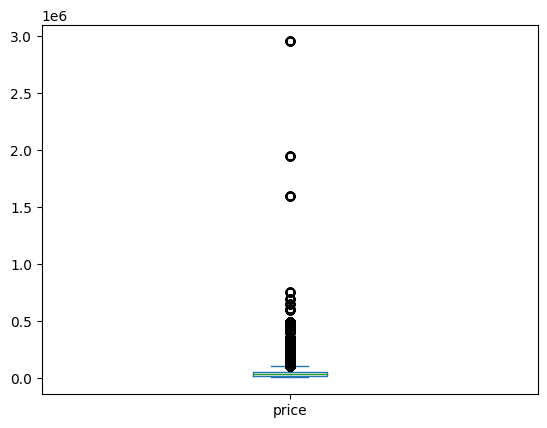

In [11]:
df.price.plot.box()

In [12]:
outliers = df[df["price"] > 5.5e5]
outliers
df = df[df["price"]< 5.5e5]

<AxesSubplot: >

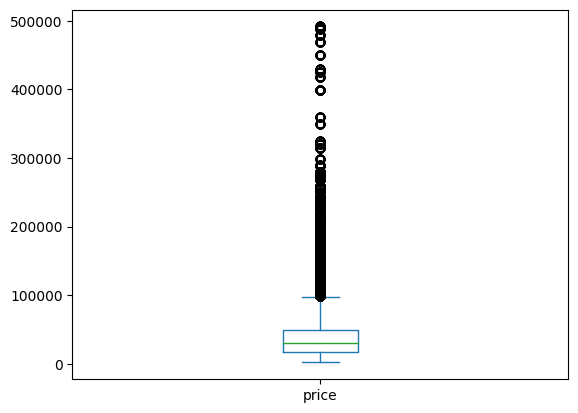

In [13]:
df.price.plot.box()

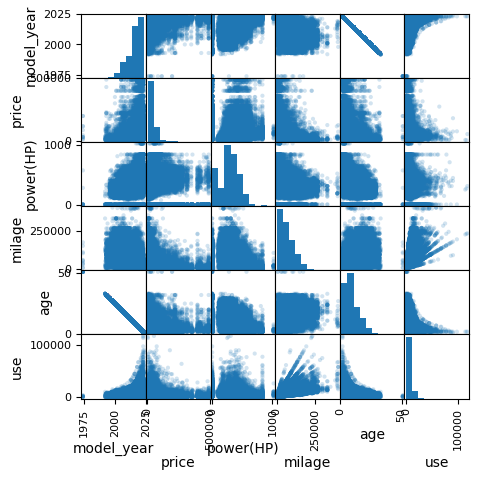

In [14]:
df["age"] = 2025 - df["model_year"]
df["use"] = df["milage"]/df["age"]
df["power(HP)"] = pd.to_numeric(df["power(HP)"])
df_num = df[["model_year", "price", "power(HP)", "milage", "age", "use"]]
pd.plotting.scatter_matrix(df_num, alpha = 0.2, figsize = (5,5), diagonal = 'hist')
plt.show()

/var/folders/4w/r3wqy9sx29x_q3nlp7zqhv480000gn/T/ipykernel_27063/1494657365.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  int_col_exp = df.groupby(["int_col"]).mean()


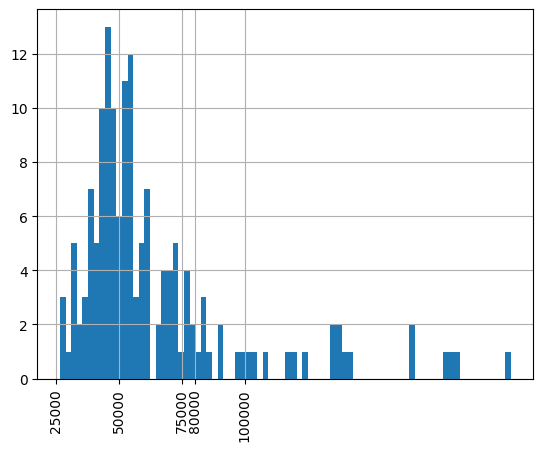

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,power(HP),displacement(L),n_cylinders,age,use,fancy_int_col
0,0,mini,cooper s base,2007,213000,gasoline,172.0hp 1.6l 4 cylinder engine gasoline fuel,a/t,yellow,gray,none reported,yes,4200,172.0,1.6,0.0,18,11833.333333,False
1,1,lincoln,ls v8,2002,143250,gasoline,252.0hp 3.9l 8 cylinder engine gasoline fuel,a/t,silver,beige,at least 1 accident or damage reported,yes,4999,252.0,3.9,0.0,23,6228.260870,False
2,2,chevrolet,silverado 2500 lt,2002,136731,flex,320.0hp 5.3l 8 cylinder engine flex fuel capab...,a/t,blue,gray,none reported,yes,13900,320.0,5.3,0.0,23,5944.826087,False
3,3,genesis,g90 5.0 ultimate,2017,19500,gasoline,420.0hp 5.0l 8 cylinder engine gasoline fuel,transmission w/dual shift mode,black,black,none reported,yes,45000,420.0,5.0,0.0,8,2437.500000,False
4,4,mercedes-benz,metris base,2021,7388,gasoline,208.0hp 2.0l 4 cylinder engine gasoline fuel,7-speed a/t,black,beige,none reported,yes,97500,208.0,2.0,0.0,4,1847.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,cadillac,escalade esv platinum,2017,49000,gasoline,420.0hp 6.2l 8 cylinder engine gasoline fuel,transmission w/dual shift mode,white,beige,none reported,yes,27500,420.0,6.2,0.0,8,6125.000000,False
188529,188529,mercedes-benz,amg c 43 amg c 43 4matic,2018,28600,gasoline,385.0hp 3.0l v6 cylinder engine gasoline fuel,8-speed a/t,white,black,at least 1 accident or damage reported,yes,30000,385.0,3.0,0.0,7,4085.714286,False
188530,188530,mercedes-benz,amg glc 63 base 4matic,2021,13650,gasoline,469.0hp 4.0l 8 cylinder engine gasoline fuel,7-speed a/t,white,black,none reported,yes,86900,469.0,4.0,0.0,4,3412.500000,False
188531,188531,audi,s5 3.0t prestige,2022,13895,gasoline,3.0l,1-speed automatic,daytona gray pearl effect,black,none reported,NaN,84900,3.5,3.0,6,3,4631.666667,False


In [15]:
int_col_exp = df.groupby(["int_col"]).mean()
int_col_exp = int_col_exp.sort_values(by = ["price"], ascending = False)
expensive_int_cols = int_col_exp[int_col_exp["price"] > 80000].index.tolist()

int_col_exp["price"].hist(bins = 80)
plt.xticks((25000, 50000, 75000, 80000, 100000), fontsize = 10, rotation = 90)
plt.show()

df[df["int_col"].isin(expensive_int_cols)]
df["fancy_int_col"] = df["int_col"].isin(expensive_int_cols) 
df

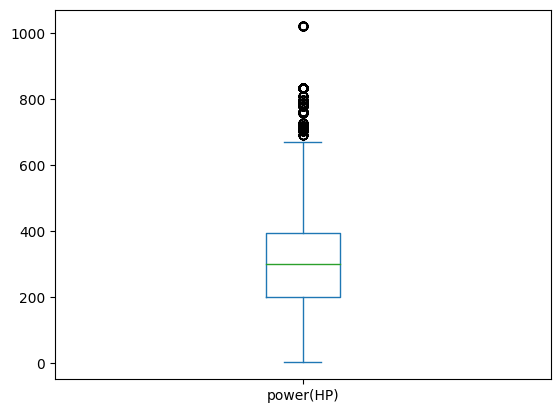

In [16]:
df["power(HP)"].plot.box()
df.loc[(df["power(HP)"]>1000) & (df["brand"] == "ford"), "power(HP)"] = 480

In [17]:
grouped_by_mean = df.groupby(['brand']).mean()['price'].reset_index()

# Definir los límites de los bins
bins = [0, 30000, 50000, 90000, float('inf')]
labels = ['Low-end', 'Mid-end', 'High-end', 'Luxury']

# Aplicar pd.cut para categorizar los precios
df['price_category'] = pd.cut(grouped_by_mean['price'], bins=bins, labels=labels, right=False)
df


/var/folders/4w/r3wqy9sx29x_q3nlp7zqhv480000gn/T/ipykernel_27063/2604408759.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_by_mean = df.groupby(['brand']).mean()['price'].reset_index()


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,power(HP),displacement(L),n_cylinders,age,use,fancy_int_col,price_category
0,0,mini,cooper s base,2007,213000,gasoline,172.0hp 1.6l 4 cylinder engine gasoline fuel,a/t,yellow,gray,none reported,yes,4200,172.0,1.6,0.0,18,11833.333333,False,Low-end
1,1,lincoln,ls v8,2002,143250,gasoline,252.0hp 3.9l 8 cylinder engine gasoline fuel,a/t,silver,beige,at least 1 accident or damage reported,yes,4999,252.0,3.9,0.0,23,6228.260870,False,High-end
2,2,chevrolet,silverado 2500 lt,2002,136731,flex,320.0hp 5.3l 8 cylinder engine flex fuel capab...,a/t,blue,gray,none reported,yes,13900,320.0,5.3,0.0,23,5944.826087,False,Luxury
3,3,genesis,g90 5.0 ultimate,2017,19500,gasoline,420.0hp 5.0l 8 cylinder engine gasoline fuel,transmission w/dual shift mode,black,black,none reported,yes,45000,420.0,5.0,0.0,8,2437.500000,False,Mid-end
4,4,mercedes-benz,metris base,2021,7388,gasoline,208.0hp 2.0l 4 cylinder engine gasoline fuel,7-speed a/t,black,beige,none reported,yes,97500,208.0,2.0,0.0,4,1847.000000,False,Luxury
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,cadillac,escalade esv platinum,2017,49000,gasoline,420.0hp 6.2l 8 cylinder engine gasoline fuel,transmission w/dual shift mode,white,beige,none reported,yes,27500,420.0,6.2,0.0,8,6125.000000,False,NaN
188529,188529,mercedes-benz,amg c 43 amg c 43 4matic,2018,28600,gasoline,385.0hp 3.0l v6 cylinder engine gasoline fuel,8-speed a/t,white,black,at least 1 accident or damage reported,yes,30000,385.0,3.0,0.0,7,4085.714286,False,NaN
188530,188530,mercedes-benz,amg glc 63 base 4matic,2021,13650,gasoline,469.0hp 4.0l 8 cylinder engine gasoline fuel,7-speed a/t,white,black,none reported,yes,86900,469.0,4.0,0.0,4,3412.500000,False,NaN
188531,188531,audi,s5 3.0t prestige,2022,13895,gasoline,3.0l,1-speed automatic,daytona gray pearl effect,black,none reported,NaN,84900,3.5,3.0,6,3,4631.666667,False,NaN


In [18]:
grouped_by_mean_age = df.groupby(['age']).mean()['price']

grouped_by_mean_age

age_bins = [0, 5, 10, 30, float('inf')]
age_labels = ['Very Recent', 'Recent', 'Old', 'Vintage']

# Aplicar pd.cut para categorizar los precios
df['Age_bins'] = pd.cut(grouped_by_mean['price'], bins=age_bins, labels=age_labels, right=True)
df

/var/folders/4w/r3wqy9sx29x_q3nlp7zqhv480000gn/T/ipykernel_27063/997131378.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_by_mean_age = df.groupby(['age']).mean()['price']


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,...,clean_title,price,power(HP),displacement(L),n_cylinders,age,use,fancy_int_col,price_category,Age_bins
0,0,mini,cooper s base,2007,213000,gasoline,172.0hp 1.6l 4 cylinder engine gasoline fuel,a/t,yellow,gray,...,yes,4200,172.0,1.6,0.0,18,11833.333333,False,Low-end,Vintage
1,1,lincoln,ls v8,2002,143250,gasoline,252.0hp 3.9l 8 cylinder engine gasoline fuel,a/t,silver,beige,...,yes,4999,252.0,3.9,0.0,23,6228.260870,False,High-end,Vintage
2,2,chevrolet,silverado 2500 lt,2002,136731,flex,320.0hp 5.3l 8 cylinder engine flex fuel capab...,a/t,blue,gray,...,yes,13900,320.0,5.3,0.0,23,5944.826087,False,Luxury,Vintage
3,3,genesis,g90 5.0 ultimate,2017,19500,gasoline,420.0hp 5.0l 8 cylinder engine gasoline fuel,transmission w/dual shift mode,black,black,...,yes,45000,420.0,5.0,0.0,8,2437.500000,False,Mid-end,Vintage
4,4,mercedes-benz,metris base,2021,7388,gasoline,208.0hp 2.0l 4 cylinder engine gasoline fuel,7-speed a/t,black,beige,...,yes,97500,208.0,2.0,0.0,4,1847.000000,False,Luxury,Vintage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,cadillac,escalade esv platinum,2017,49000,gasoline,420.0hp 6.2l 8 cylinder engine gasoline fuel,transmission w/dual shift mode,white,beige,...,yes,27500,420.0,6.2,0.0,8,6125.000000,False,NaN,NaN
188529,188529,mercedes-benz,amg c 43 amg c 43 4matic,2018,28600,gasoline,385.0hp 3.0l v6 cylinder engine gasoline fuel,8-speed a/t,white,black,...,yes,30000,385.0,3.0,0.0,7,4085.714286,False,NaN,NaN
188530,188530,mercedes-benz,amg glc 63 base 4matic,2021,13650,gasoline,469.0hp 4.0l 8 cylinder engine gasoline fuel,7-speed a/t,white,black,...,yes,86900,469.0,4.0,0.0,4,3412.500000,False,NaN,NaN
188531,188531,audi,s5 3.0t prestige,2022,13895,gasoline,3.0l,1-speed automatic,daytona gray pearl effect,black,...,NaN,84900,3.5,3.0,6,3,4631.666667,False,NaN,NaN


In [19]:
def extract_gears(transmission):
    # Buscar el número de velocidades
    match = re.search(r'(\d+)-?speed', transmission, re.IGNORECASE)
    if match:
        return int(match.group(1))
    else:
        return 6 # Si no se encuentra, devuelve None

def is_manual_or_automatic(transmission):
    if "m/t" in transmission.lower() or "manual" in transmission.lower():
        return "manual"
    elif "automatic" in transmission.lower() or "a/t" in transmission.lower() or "cvt" in transmission.lower():
        return "automatic"
    else:
        return "other"  # Para transmisiones no clasificadas

    
df['num_gears'] = df['transmission'].apply(extract_gears)
df['transmission_type'] = df['transmission'].apply(is_manual_or_automatic)

df[["num_gears", "transmission_type"]]

,num_gears,transmission_type
0,6,automatic
1,6,automatic
2,6,automatic
3,6,other
4,7,automatic
...,...,...
188528,6,other
188529,8,automatic
188530,7,automatic
188531,1,automatic


In [20]:
#plt.figure(figsize = (25, 20))
#df.groupby(['int_col']).mean()['price'].sort_values(ascending = False).plot.bar(fontsize = 10, color = 'g')
#plt.title("The average price of cars of different companies", fontsize = 20)
#plt.show()

grouped_by_mean = df.groupby(['int_col']).mean()['price']

lux_int_col = grouped_by_mean.sort_values(ascending= False).nlargest(20).index.to_list()

df['lux_int_col'] = df["int_col"].isin(lux_int_col).apply(int)



/var/folders/4w/r3wqy9sx29x_q3nlp7zqhv480000gn/T/ipykernel_27063/3857945706.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_by_mean = df.groupby(['int_col']).mean()['price']


In [21]:
#plt.figure(figsize = (25, 20))
#df.groupby(['ext_col']).mean()['price'].sort_values(ascending = False).plot.bar(fontsize = 10, color = 'g')
#plt.title("The average price of cars of different companies", fontsize = 20)
#plt.show()

grouped_by_mean_ext = df.groupby('ext_col')['price'].mean()

col_bins = [0, 80000, 150000, float('inf')]
col_labels = ['normal', 'top', 'luxury']

grouped_by_mean_ext_bins = pd.cut(grouped_by_mean_ext, bins=col_bins, labels=col_labels, right=True)

grouped_colors = pd.DataFrame({'mean_price': grouped_by_mean_ext, 'ext_col_bins': grouped_by_mean_ext_bins})

df['ext_col_bins'] = df['ext_col'].map(grouped_colors['ext_col_bins'])

In [51]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    pass

In [76]:
#plt.figure(figsize = (25, 20))
#df.groupby(['brand']).mean()['price'].sort_values(ascending = False).plot.bar(fontsize = 10, color = 'g')
#plt.title("The average price of cars of different companies", fontsize = 20)
#plt.show()

luxury_models = df.groupby(['model']).mean()['price'].sort_values(ascending = False).nlargest(40).index.to_list()
df["model"][df["model"].isin(luxury_models)].value_counts()


/var/folders/4w/r3wqy9sx29x_q3nlp7zqhv480000gn/T/ipykernel_27063/111732234.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  luxury_models = df.groupby(['model']).mean()['price'].sort_values(ascending = False).nlargest(40).index.to_list()


911 gt3                            386
911 turbo s                        362
cullinan                           205
urus base                          196
huracan evo base                   138
911 gt3 rs                         133
bentayga v8                         96
bentayga azure first edition        84
continental gt v8                   80
rs q8 4.0t quattro                  76
bentayga speed                      73
roma base                           73
huracan lp580-2s                    64
720s performance                    62
911 r                               60
continental gt v8 s                 48
488 gtb base                        46
martin dbx base                     43
huracan lp580-2                     43
bentayga s                          37
murcielago base                     37
f12berlinetta base                  32
911 gt2 rs                          29
huracan tecnica coupe               29
570s base                           29
flying spur v8           

In [1]:
import pandas as pd
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from sklearn.cluster import AgglomerativeClustering

# Ejemplo de lista de modelos de coches
car_models = df.model.value_counts().index.to_list()

models_df = pd.DataFrame(car_models, columns=['model'])

# Normalizar los nombres
models_df['model'] = models_df['model'].str.lower().str.strip()

# Función para encontrar grupos por similitud
def group_models(models, threshold=70):
    groups = []
    for model in models:
        found = False
        for group in groups:
            if fuzz.ratio(model, group[0]) >= threshold:
                group.append(model)
                found = True
                break
        if not found:
            groups.append([model])
    return groups

# Agrupar modelos
model_groups = group_models(models_df['model'].tolist())

# Convertir a DataFrame para visualización
grouped_df = pd.DataFrame({'Base Model': [group[0] for group in model_groups], 
                           'Models': [', '.join(group) for group in model_groups]})



/opt/anaconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


NameError: name 'df' is not defined

In [119]:
car_dict={}
for model in car_models:
    car_dict.update({model: 
                    ",".join(str(x) for x in  grouped_df["Models"][grouped_df["Models"].str.contains(model)].values)})

df = df.replace({"model": car_dict})


In [23]:
import difflib

vc = df.model.value_counts()
vc[vc <100]

models_to_keep = vc[vc >= 100].index

df_filtered = df[df['model'].isin(models_to_keep)]

known_models = df_filtered['model'].unique().tolist()

def find_closest_model(unknown_model, known_models):
    if unknown_model in known_models:
        return unknown_model
    closest_match = difflib.get_close_matches(unknown_model, known_models, n=1, cutoff=0.5)
    return closest_match[0] if closest_match else 'unknown'

# Aplicar a la columna 'model'
df['model'] = df['model'].apply(lambda x: find_closest_model(x, known_models))

# Ver resultados
df['model'].value_counts()

unknown                   4395
F-150 XLT                 3027
M3 Base                   2302
M4 Base                   1787
Camaro 2SS                1731
                          ... 
X5 PHEV xDrive45e          105
1500 Tradesman/Express     104
Suburban RST               102
G70 3.3T Advanced          102
Nautilus Reserve           101
Name: model, Length: 481, dtype: int64

In [22]:
hp_pattern = r'(\d+\.?\d*)(\s*hp)'      

liters_pattern = r'(\d+\.?\d*)(\s*l)'     
liters_pattern_full = r'(\d+\.?\d*\s*liter)' 

cylinder_pattern = r'(\d+)\s*cylinder'
cylinder_pattern_letter = r'v|h|w|i-?(\d)'
cylinder_pattern_flat = r'flat\s(\d)'

fuel_list_engine = ["plug-in", "diesel", "hybrid", "gdi", "pdi", "gasoline", 
                    "electric", "hydrogen", "flexible", "flex"]

fuel_list_dict= {"plug-in": "plug-in hybrid",
                 "gdi": "gasoline",
                 "pdi": "diesel",
                 "flexible": "flex",
                 "e85 flex fuel": "flex"}

fuel_list = ["plug-in hybrid", "hybrid", "gasoline",
             "diesel", "flex", "electric", "hydrogen"]

def remove_numbers_from_string(s):
    result = ''.join([i for i in s if not i.isdigit()])
    result = ''.join([i for i in result if not i == "."])

    return result

def fuel_parser(s):
    for fuel in fuel_list:

        if fuel in s:
            return fuel
        
    for fuel in fuel_list_engine:
        if fuel in s:
            return fuel_list_dict[fuel]
    
    return pd.NA

def extract_engine_info(engine_str):
    hp = re.search(hp_pattern, engine_str)
    
    liters = re.search(liters_pattern, engine_str)
    if not liters:
        liters = re.search(liters_pattern_full, engine_str)
        
    cylinders_str = False    
    cylinders = re.search(cylinder_pattern, engine_str)
    if not cylinders:
        cylinders = re.search(cylinder_pattern_letter, engine_str)
        if not cylinders:
            cylinders = re.search(cylinder_pattern_flat, engine_str)
    
    return {
        'power(HP)': float(hp.group(1)) if hp else pd.NA,
        'displacement(L)': float(liters.group(1)) if liters else pd.NA,
        'n_cylinders': float(cylinders_str) if cylinders else pd.NA,
    }

def estimate_cylinders(engine_string):
    if "turbo" in engine_string:
        return 4  # Muchos motores turbo son I4 o V6
    else:
        return 6  

def estimate_displacement(engine_string, cylinders):
    if "turbo" in engine_string:
                return 2.0  # Motores turbo tienden a ser más pequeños
    if cylinders == 4:
        return 2.5
    if cylinders == 6:
        return 3.5
    if cylinders in [8,10,12,14,16]:
        return 5
    
    return 3

def estimate_horsepower(engine_str, cylinders):
    if cylinders == 8:
        if 'Turbo' in engine_str:
            return (400 + 500) / 2  
        elif 'GDI' in engine_str or 'DOHC' in engine_str or 'MPFI' in engine_str:
            return (350 + 450) / 2  
        else:
            return (300 + 400) / 2
    elif cylinders == 6:
        if 'Turbo' in engine_str:
            return (300 + 400) / 2 
        elif 'GDI' in engine_str or 'DOHC' in engine_str or 'MPFI' in engine_str:
            return (250 + 350) / 2 
        else:
            return (200 + 300) / 2
    elif cylinders == 4:
        if 'Turbo' in engine_str:
            return (200 + 300) / 2
        elif 'GDI' in engine_str or 'MPFI' in engine_str or 'DOHC' in engine_str:
            return (150 + 250) / 2 
        else:
            return (100 + 200) / 2 
    elif cylinders == 10:
        if 'Turbo' in engine_str:
            return (600 + 800) / 2
        elif 'GDI' in engine_str or 'DOHC' in engine_str or 'MPFI' in engine_str:
            return (500 + 600) / 2  
        else:
            return (400 + 600) / 2 
    elif cylinders == 12:
        if 'Turbo' in engine_str:
            return (700 + 900) / 2 
        elif 'GDI' in engine_str or 'DOHC' in engine_str or 'MPFI' in engine_str:
            return (600 + 800) / 2  
        else:
            return (500 + 700) / 2 
    elif 'OHV' in engine_str:
        return (200 + 300) / 2 
    else:
        return pd.NA
    
class EngineParser(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    #HABER QUITADO VALORES NA Y HABER HECHO LOWER LOS STRINGS
    def transform(self, X, y=None):
        X["fuel_type_engine"] = X["engine"].apply(fuel_parser)
        X["fuel_type"] = X["fuel_type"].apply(fuel_parser)
        condition = (df["fuel_type"] != df["fuel_type_engine"]) & (~df["fuel_type_engine"].isna())
        X.loc[condition, "fuel_type"] = X["fuel_type_engine"]
        X = X.drop(columns = ["fuel_type_engine"])

        engine_info_dicts = X["engine"].apply(extract_engine_info)
        new_features = pd.DataFrame(list(engine_info_dicts))
        X["power(HP)"] = new_features["power(HP)"]
        X["displacement(L)"] = new_features["displacement(L)"]
        X["n_cylinders"] = new_features["n_cylinders"]
        
        X.loc[(X["displacement(L)"].isna()) & (X["fuel_type"] == "electric"),
        "displacement(L)"] = 0
        X.loc[X["fuel_type"].isna(), "fuel_type"] = "gasoline"
        X.loc[(X["n_cylinders"].isna()) & (X["fuel_type"] == "hybrid"),
        "n_cylinders"] = 4
        
        estimated_cylinders = X["engine"][X["n_cylinders"].isna()].apply(estimate_cylinders)
        X.loc[X["n_cylinders"].isna(), "n_cylinders"] = estimated_cylinders

        estimated_displacement = X[X["displacement(L)"].isna()].apply(lambda row: estimate_displacement(row['engine'], 
                                                                row['n_cylinders']), axis=1)
        X.loc[X["displacement(L)"].isna(), "displacement(L)"] = estimated_displacement

        estimated_hp = X[X["power(HP)"].isna()].apply(lambda row: estimate_displacement(row['engine'], 
                                                                row['n_cylinders']), axis=1)
        X.loc[X["power(HP)"].isna(), "power(HP)"] = estimated_hp
        
        X.drop(columns = "engine", inplace= True)
        
        X["power(HP)"] = pd.to_numeric(X["power(HP)"])
        
        return X
        
        
class StringLower(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.applymap(lambda s: s.lower() if type(s) == str else s)
        return X